Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Loss: 1.3874
Epoch [2/5], Loss: 1.0053
Epoch [3/5], Loss: 0.8440
Epoch [4/5], Loss: 0.7216
Epoch [5/5], Loss: 0.6140
Accuracy on the test set: 72.28%


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

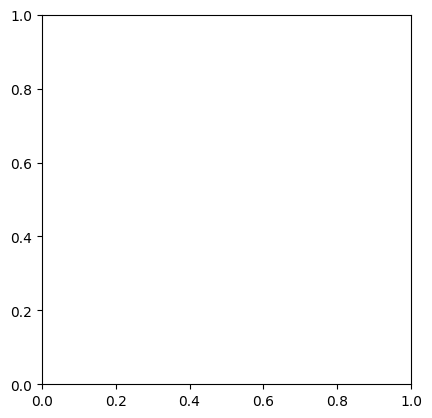

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 5

# Data preparation: Normalize CIFAR-10 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels (RGB), 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels, 64 output channels
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Fully connected layer, output size after convolution
        self.fc2 = nn.Linear(256, 10)  # Final output layer with 10 classes (CIFAR-10)
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling layer to reduce the spatial size

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply convolution + ReLU + Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply convolution + ReLU + Pooling
        x = x.view(-1, 64 * 8 * 8)  # Flatten the output for the fully connected layer
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = self.fc2(x)  # Output layer
        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)  # Move the model to the GPU if available
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing Loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation for testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

# Display a sample image and its prediction
def predict_and_display(model, dataset, index):
    image, label = dataset[index]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    output = model(image)
    _, predicted = torch.max(output, 1)

    # Display the image
    plt.imshow(image.squeeze().permute(1, 2, 0) * 0.5 + 0.5)  # Denormalize the image
    plt.title(f"True Label: {dataset.classes[label]}, Predicted: {dataset.classes[predicted.item()]}")
    plt.axis("off")
    plt.show()

# Example usage: Display image at index 0
predict_and_display(model, test_dataset, 0)
